importing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# prediction library
!pip install prophet --quiet
from prophet import Prophet

mounting to google drive for data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


loading data

In [3]:
# Load data from CSV files into pandas DataFrames
path = "/content/drive/MyDrive/Dataset/"
stores_df = pd.read_csv(path+'stores.csv')
order_df = pd.read_csv(path+'orders.csv')
deliveries_df = pd.read_csv(path+'deliveries.csv')
drivers_df = pd.read_csv(path+'drivers.csv')
payments_df = pd.read_csv(path+'payments.csv')

# Task2

In [4]:
stores_df["store_segment"].value_counts()

store_segment
GOOD    567
FOOD    384
Name: count, dtype: int64

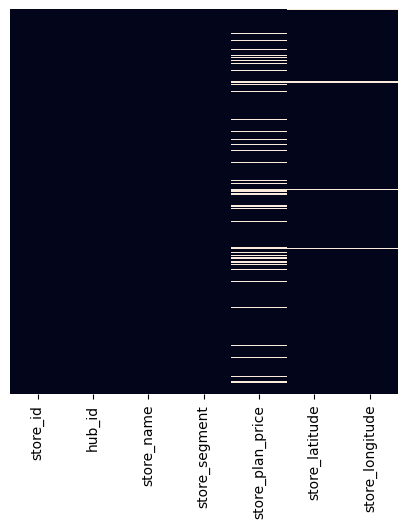

In [10]:
plt.figure(figsize=(5, 5))
sns.heatmap(stores_df.isnull(),yticklabels=False,cbar=False)
plt.show()

<p>There is no null value in store_segment <p>

In [12]:
order_df.sample(2)

,order_id,store_id,channel_id,payment_order_id,delivery_order_id,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_moment_created,order_moment_accepted,order_moment_delivered,order_moment_finished
283200,88385469,1029,21,88385469,88385469,CANCELED,32.49,0.0,0.0,4/6/2021 7:36,NaN,NaN,NaN
110293,77815574,2894,5,77815574,77815574,FINISHED,35.80,0.0,9.1,2/14/2021 23:50,2/14/2021 23:51,NaN,2/15/2021 0:33


In [11]:
order_store_df = order_df.merge(stores_df[['store_id', 'store_segment']], on='store_id', how='left')
order_store_df.head(5)

,order_id,store_id,channel_id,payment_order_id,delivery_order_id,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_moment_created,order_moment_accepted,order_moment_delivered,order_moment_finished,store_segment
0,68405119,3512,5,68405119,68405119,CANCELED,62.7,0.0,NaN,1/1/2021 0:01,NaN,NaN,NaN,FOOD
1,68405123,3512,5,68405123,68405123,CANCELED,62.7,0.0,NaN,1/1/2021 0:04,NaN,NaN,NaN,FOOD
2,68405206,3512,5,68405206,68405206,CANCELED,115.5,0.0,NaN,1/1/2021 0:13,NaN,NaN,NaN,FOOD
3,68405465,3401,5,68405465,68405465,CANCELED,55.9,0.0,NaN,1/1/2021 0:19,NaN,NaN,NaN,FOOD
4,68406064,3401,5,68406064,68406064,CANCELED,37.9,0.0,NaN,1/1/2021 0:26,NaN,NaN,NaN,FOOD


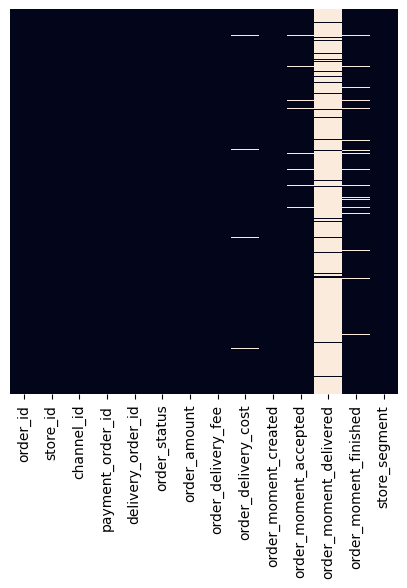

In [13]:
plt.figure(figsize=(5, 5))
sns.heatmap(order_store_df.isnull(),yticklabels=False,cbar=False)
plt.show()

<p> There is no null in ["store_segment"] but ["order_moment_delivered"] is mostly null <p>

In [14]:
segment_distribution = order_store_df['store_segment'].value_counts()
print(segment_distribution)

store_segment
FOOD    321775
GOOD     47224
Name: count, dtype: int64


In [15]:
# Convert the 'order_moment_created' column to datetime format
order_store_df['order_moment_created'] = pd.to_datetime(order_store_df['order_moment_created'], errors='coerce')

In [17]:
pd.Grouper(key='order_moment_created', freq='D')

TimeGrouper(key='order_moment_created', freq=<Day>, axis=0, sort=True, dropna=True, closed='left', label='left', how='mean', convention='e', origin='start_day')

In [19]:
daily_order_counts = order_store_df.groupby([pd.Grouper(key='order_moment_created', freq='D'), 'store_segment'])['order_id'].count().reset_index(name='order_count')
daily_order_counts

,order_moment_created,store_segment,order_count
0,2021-01-01,FOOD,1120
1,2021-01-01,GOOD,11
2,2021-01-02,FOOD,2388
3,2021-01-02,GOOD,59
4,2021-01-03,FOOD,3012
...,...,...,...
235,2021-04-28,GOOD,414
236,2021-04-29,FOOD,2719
237,2021-04-29,GOOD,369
238,2021-04-30,FOOD,3547


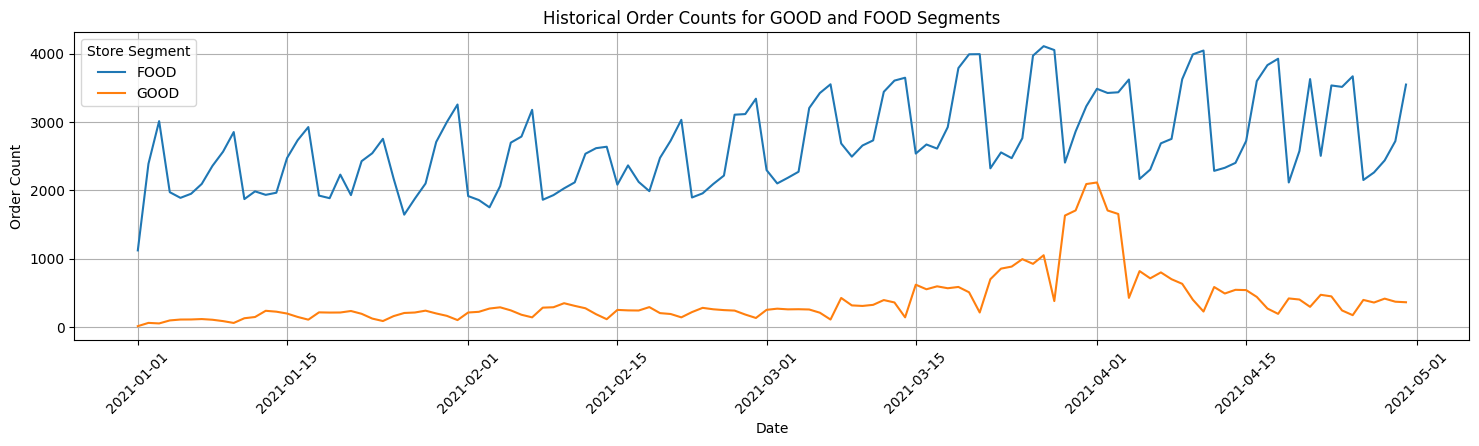

In [20]:
# sns.set_style("whitegrid")

plt.figure(figsize=(18, 4))
sns.lineplot(x='order_moment_created', y='order_count', hue='store_segment', data=daily_order_counts)
plt.title('Historical Order Counts for GOOD and FOOD Segments')
plt.xlabel('Date')
plt.ylabel('Order Count')
plt.legend(title='Store Segment')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## [prediction]

In [21]:
good_orders = daily_order_counts[daily_order_counts['store_segment'] == 'GOOD']
food_orders = daily_order_counts[daily_order_counts['store_segment'] == 'FOOD']

In [22]:
good_orders_prophet = good_orders.rename(columns={'order_moment_created': 'ds', 'order_count': 'y'})
# Initialize and fit the Prophet model for 'GOOD' segment
# Predict future order counts
# Create a dataframe to hold predictions for the next two months

# ------- GOOD prediction -----------
model_good = Prophet()
model_good.fit(good_orders_prophet)
future_good = model_good.make_future_dataframe(periods=60)
forecast_good = model_good.predict(future_good)

# ------- FOOD prediction -----------
food_orders_prophet = food_orders.rename(columns={'order_moment_created': 'ds', 'order_count': 'y'})
model_food = Prophet()
model_food.fit(food_orders_prophet)
future_food = model_food.make_future_dataframe(periods=60)
forecast_food = model_food.predict(future_food)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp84lklkhk/ofekxns1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp84lklkhk/x_swep2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1077', 'data', 'file=/tmp/tmp84lklkhk/ofekxns1.json', 'init=/tmp/tmp84lklkhk/x_swep2y.json', 'output', 'file=/tmp/tmp84lklkhk/prophet_modelo63_ktle/prophet_model-20240807065914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:59:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:59:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

In [23]:
# ------- GOOD  -----------
good_orders_prophet = good_orders_prophet.rename(columns={'ds': 'date', 'y': 'order_count'})
forecast_good = forecast_good.rename(columns={'ds': 'date', 'yhat': 'order_count', 'yhat_lower': 'lower_bound', 'yhat_upper': 'upper_bound'})
good_orders_prophet['type'] = 'Historical'
forecast_good['type'] = 'Forecast'
combined_good = pd.concat([good_orders_prophet[['date', 'order_count', 'type']], forecast_good[['date', 'order_count', 'lower_bound', 'upper_bound', 'type']]])
combined_good['store_segment'] = 'GOOD'

# ------- FOOD  -----------
food_orders_prophet = food_orders_prophet.rename(columns={'ds': 'date', 'y': 'order_count'})
forecast_food = forecast_food.rename(columns={'ds': 'date', 'yhat': 'order_count', 'yhat_lower': 'lower_bound', 'yhat_upper': 'upper_bound'})
food_orders_prophet['type'] = 'Historical'
forecast_food['type'] = 'Forecast'
combined_food = pd.concat([food_orders_prophet[['date', 'order_count', 'type']], forecast_food[['date', 'order_count', 'lower_bound', 'upper_bound', 'type']]])
combined_food['store_segment'] = 'FOOD'
# ------- combined  -----------
combined_data = pd.concat([combined_good, combined_food])
combined_data.sample(10)


,date,order_count,type,lower_bound,upper_bound,store_segment
218,2021-04-20,2574.000000,Historical,NaN,NaN,FOOD
179,2021-06-29,2863.851752,Forecast,2475.582284,3263.003508,FOOD
102,2021-04-13,651.811034,Forecast,205.599250,1076.399412,GOOD
157,2021-06-07,941.458655,Forecast,577.753772,1343.437776,GOOD
42,2021-02-12,2842.759133,Forecast,2478.333749,3241.159847,FOOD
37,2021-01-19,210.000000,Historical,NaN,NaN,GOOD
13,2021-01-14,1864.304891,Forecast,1481.525265,2227.494871,FOOD
52,2021-01-27,1878.000000,Historical,NaN,NaN,FOOD
23,2021-01-24,-14.869647,Forecast,-432.997802,390.044255,GOOD
132,2021-03-08,2685.000000,Historical,NaN,NaN,FOOD


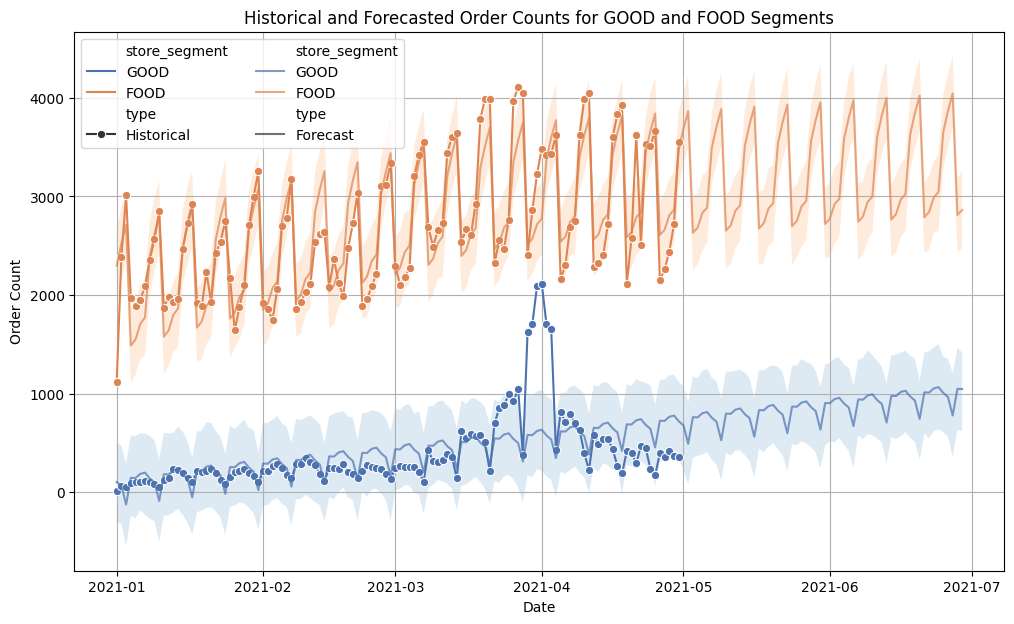

In [24]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=combined_data[combined_data['type'] == 'Historical'], x='date', y='order_count', hue='store_segment', style='type', markers=True, dashes=False, palette='deep')
sns.lineplot(data=combined_data[combined_data['type'] == 'Forecast'], x='date', y='order_count', hue='store_segment', style='type', markers=False, dashes=True, palette='deep',alpha=0.7)

# Adding the confidence intervals for the forecast
for segment in ['GOOD', 'FOOD']:
    forecast_data = combined_data[(combined_data['type'] == 'Forecast') & (combined_data['store_segment'] == segment)]
    plt.fill_between(forecast_data['date'], forecast_data['lower_bound'], forecast_data['upper_bound'], alpha=0.15)

plt.title('Historical and Forecasted Order Counts for GOOD and FOOD Segments')
plt.xlabel('Date')
plt.ylabel('Order Count')
plt.legend(ncol=2,loc='upper left')
# plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Task3

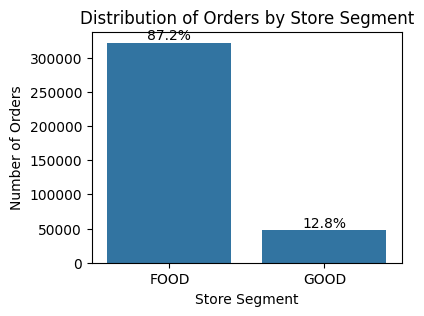

In [25]:
plt.figure(figsize=(4, 3))
total_orders = len(order_store_df)
sns_plot = sns.countplot(x='store_segment', data=order_store_df)
plt.title('Distribution of Orders by Store Segment')
plt.xlabel('Store Segment')
plt.ylabel('Number of Orders')

for p in sns_plot.patches:
    percentage = f'{100 * p.get_height() / total_orders:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    sns_plot.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()


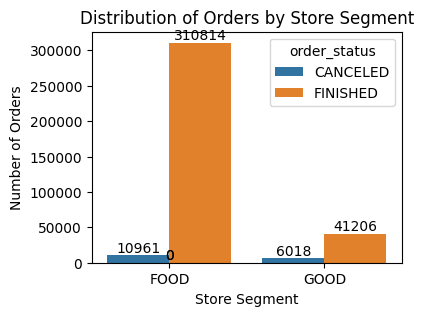

In [28]:
plt.figure(figsize=(4, 3))
sns_plot = sns.countplot(x='store_segment',hue='order_status', data=order_store_df)
plt.title('Distribution of Orders by Store Segment')
plt.xlabel('Store Segment')
plt.ylabel('Number of Orders')

for p in sns_plot.patches:
    percentage = f'{p.get_height():.0f}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    sns_plot.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

# Task4

In [29]:
payments_df["payment_method"].value_counts()

payment_method
ONLINE                      312377
VOUCHER                      48570
DEBIT                        12347
MEAL_BENEFIT                  6687
STORE_DIRECT_PAYMENT          6574
CREDIT                        4966
DEBIT_STORE                   1997
VOUCHER_STORE                 1683
PAYMENT_LINK                  1613
CREDIT_STORE                  1266
MONEY                         1190
VOUCHER_DC                     465
INSTALLMENT_CREDIT_STORE       452
VOUCHER_OL                     347
BANK_TRANSFER_DC               300
Name: count, dtype: int64

In [30]:
order_df = pd.merge(order_df, payments_df[["payment_order_id","payment_method"]], how='left', left_on='payment_order_id', right_on='payment_order_id')

In [31]:
# Convert the 'order_moment_created' column to datetime format
order_df['order_moment_created'] = pd.to_datetime(order_df['order_moment_created'], errors='coerce')

In [32]:
# Check for null values and drop records with null values in 'order_moment_created'
initial_count = len(order_df)
order_df = order_df.dropna(subset=['order_moment_created'])
final_count = len(order_df)
print(f"Number of records removed due to null 'order_moment_created': {initial_count - final_count}")

Number of records removed due to null 'order_moment_created': 0


In [33]:
# Extract the hour from 'order_moment_created'
order_df['order_hour_created'] = order_df['order_moment_created'].dt.hour
order_df.head(20)

,order_id,store_id,channel_id,payment_order_id,delivery_order_id,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_moment_created,order_moment_accepted,order_moment_delivered,order_moment_finished,payment_method,order_hour_created
0,68405119,3512,5,68405119,68405119,CANCELED,62.70,0.00,NaN,2021-01-01 00:01:00,NaN,NaN,NaN,NaN,0
1,68405123,3512,5,68405123,68405123,CANCELED,62.70,0.00,NaN,2021-01-01 00:04:00,NaN,NaN,NaN,NaN,0
2,68405206,3512,5,68405206,68405206,CANCELED,115.50,0.00,NaN,2021-01-01 00:13:00,NaN,NaN,NaN,NaN,0
3,68405465,3401,5,68405465,68405465,CANCELED,55.90,0.00,NaN,2021-01-01 00:19:00,NaN,NaN,NaN,NaN,0
4,68406064,3401,5,68406064,68406064,CANCELED,37.90,0.00,NaN,2021-01-01 00:26:00,NaN,NaN,NaN,NaN,0
5,68408108,786,5,68408108,68408108,CANCELED,80.00,9.90,NaN,2021-01-01 00:56:00,NaN,NaN,NaN,NaN,0
6,68408109,1125,5,68408109,68408109,CANCELED,71.00,9.90,NaN,2021-01-01 00:56:00,NaN,NaN,NaN,NaN,0
7,68409030,1064,35,68409030,68409030,CANCELED,214.80,0.01,0.00,2021-01-01 01:56:00,1/1/2021 1:57,NaN,NaN,NaN,1
8,68410055,2181,35,68410055,68410055,FINISHED,394.80,0.01,6.00,2021-01-01 02:32:00,1/1/2021 2:33,NaN,1/2/2021 18:57,VOUCHER,2
9,68410055,2181,35,68410055,68410055,FINISHED,394.80,0.01,6.00,2021-01-01 02:32:00,1/1/2021 2:33,NaN,1/2/2021 18:57,ONLINE,2


In [53]:
order_amount_by_hour = order_df.groupby('order_hour_created').agg(
    average_order_amount=('order_amount', 'mean'),
    order_count=('order_id', 'size')
).reset_index()
order_amount_by_hour.head(24)

,order_hour_created,average_order_amount,order_count
0,0,85.599190,30804
1,1,89.192049,4954
2,2,106.969005,1226
3,3,102.391568,829
4,4,110.013143,315
5,5,132.376959,490
6,6,132.355201,298
7,7,126.221700,253
8,8,147.281572,159
9,9,123.909079,152


In [54]:
quantile_threshold = order_amount_by_hour['order_count'].quantile(0.75)
quantile_threshold

31382.25

In [55]:
# peak hour
peak_hours = order_amount_by_hour[order_amount_by_hour['order_count'] > quantile_threshold]
non_peak_hours = order_amount_by_hour[order_amount_by_hour['order_count'] <= quantile_threshold]

print("Peak hours")
print(peak_hours['order_hour_created'].tolist())

Peak hours
[14, 15, 16, 21, 22, 23]


<ipython-input-56-e93f8713b0ee>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='order_hour_created', y='order_count', data=order_amount_by_hour, alpha=0.6, ax=ax2, palette=colors)


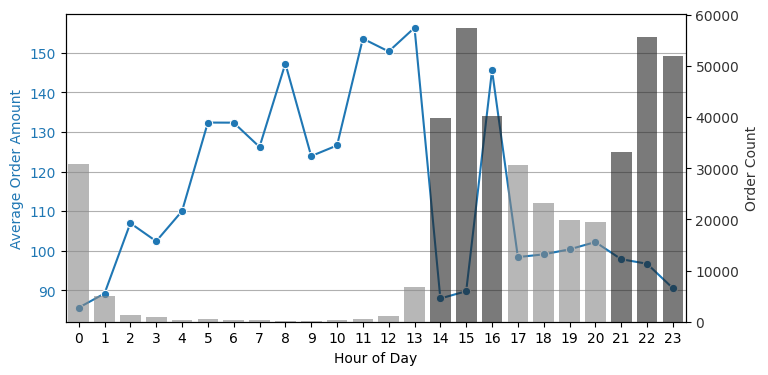

In [56]:
fig, ax1 = plt.subplots(figsize=(8, 4))

color = 'tab:blue'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Order Amount', color=color)
sns.lineplot(x='order_hour_created', y='average_order_amount', data=order_amount_by_hour, marker='o', ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(axis='y')

ax2 = ax1.twinx()
color = '#333333'
colors = ['#222222' if count > quantile_threshold else '#888888' for count in order_amount_by_hour['order_count']]
ax2.set_ylabel('Order Count', color=color)
sns.barplot(x='order_hour_created', y='order_count', data=order_amount_by_hour, alpha=0.6, ax=ax2, palette=colors)
ax2.tick_params(axis='y', labelcolor=color)

In [34]:
merge_temp = order_df.merge(stores_df[['store_id', 'store_segment']], on='store_id', how='left')
order_amount_store_by_hour = merge_temp.groupby(['order_hour_created','store_segment']).agg(
    average_order_amount=('order_amount', 'mean'),
    order_count=('order_id', 'size')
).reset_index()
order_amount_store_by_hour.head(24)

,order_hour_created,store_segment,average_order_amount,order_count
0,0,FOOD,81.164005,29603
1,0,GOOD,194.920416,1201
2,1,FOOD,76.206193,4150
3,1,GOOD,156.221032,804
4,2,FOOD,73.558593,675
5,2,GOOD,147.898276,551
6,3,FOOD,76.631676,513
7,3,GOOD,144.210633,316
8,4,FOOD,99.005137,146
9,4,GOOD,119.523018,169


In [42]:
df = order_amount_store_by_hour
df_pivot = df.pivot(index='order_hour_created', columns='store_segment', values='order_count').fillna(0)
df_pivot['total_order_count'] = df_pivot.sum(axis=1)
df_pivot

store_segment,FOOD,GOOD,total_order_count
order_hour_created,,,
0,29603,1201,30804
1,4150,804,4954
2,675,551,1226
3,513,316,829
4,146,169,315
5,126,364,490
6,76,222,298
7,11,242,253
8,1,158,159


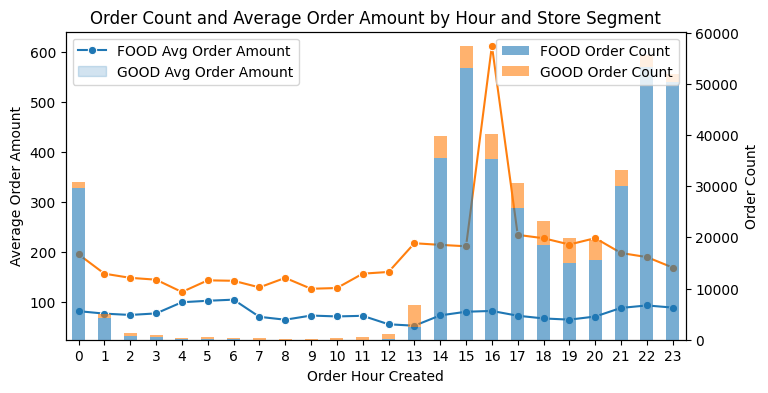

In [43]:
# Plotting
fig, ax1 = plt.subplots(figsize=(8, 4))


sns.lineplot(data=df, x='order_hour_created', y='average_order_amount', hue='store_segment', ax=ax1, marker='o')
ax1.set_ylabel('Average Order Amount')
ax1.set_xlabel('Order Hour Created')


ax2 = ax1.twinx()


df_pivot[['FOOD', 'GOOD']].plot(kind='bar', stacked=True, ax=ax2, alpha=0.6)
ax2.set_ylabel('Order Count')


plt.title('Order Count and Average Order Amount by Hour and Store Segment')
ax1.legend(['FOOD Avg Order Amount', 'GOOD Avg Order Amount'], loc='upper left')
ax2.legend(['FOOD Order Count', 'GOOD Order Count'], loc='upper right')

plt.show()

In [44]:
merged_df = pd.merge(order_df,payments_df,how="left",left_on="payment_order_id",right_on='payment_order_id')
merged_df.head(10)

,order_id,store_id,channel_id,payment_order_id,delivery_order_id,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_moment_created,order_moment_accepted,order_moment_delivered,order_moment_finished,payment_method_x,order_hour_created,payment_id,payment_amount,payment_fee,payment_method_y,payment_status
0,68405119,3512,5,68405119,68405119,CANCELED,62.7,0.00,NaN,2021-01-01 00:01:00,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,68405123,3512,5,68405123,68405123,CANCELED,62.7,0.00,NaN,2021-01-01 00:04:00,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,68405206,3512,5,68405206,68405206,CANCELED,115.5,0.00,NaN,2021-01-01 00:13:00,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,68405465,3401,5,68405465,68405465,CANCELED,55.9,0.00,NaN,2021-01-01 00:19:00,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
4,68406064,3401,5,68406064,68406064,CANCELED,37.9,0.00,NaN,2021-01-01 00:26:00,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
5,68408108,786,5,68408108,68408108,CANCELED,80.0,9.90,NaN,2021-01-01 00:56:00,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
6,68408109,1125,5,68408109,68408109,CANCELED,71.0,9.90,NaN,2021-01-01 00:56:00,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
7,68409030,1064,35,68409030,68409030,CANCELED,214.8,0.01,0.0,2021-01-01 01:56:00,1/1/2021 1:57,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
8,68410055,2181,35,68410055,68410055,FINISHED,394.8,0.01,6.0,2021-01-01 02:32:00,1/1/2021 2:33,NaN,1/2/2021 18:57,VOUCHER,2,4427917.0,118.44,0.0,VOUCHER,PAID
9,68410055,2181,35,68410055,68410055,FINISHED,394.8,0.01,6.0,2021-01-01 02:32:00,1/1/2021 2:33,NaN,1/2/2021 18:57,VOUCHER,2,4427918.0,394.81,7.9,ONLINE,PAID


In [49]:
merged_df[merged_df['payment_id']==4427918.0].head()

,order_id,store_id,channel_id,payment_order_id,delivery_order_id,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_moment_created,order_moment_accepted,order_moment_delivered,order_moment_finished,payment_method_x,order_hour_created,payment_id,payment_amount,payment_fee,payment_method_y,payment_status
9,68410055,2181,35,68410055,68410055,FINISHED,394.8,0.01,6.0,2021-01-01 02:32:00,1/1/2021 2:33,NaN,1/2/2021 18:57,VOUCHER,2,4427918.0,394.81,7.9,ONLINE,PAID
11,68410055,2181,35,68410055,68410055,FINISHED,394.8,0.01,6.0,2021-01-01 02:32:00,1/1/2021 2:33,NaN,1/2/2021 18:57,ONLINE,2,4427918.0,394.81,7.9,ONLINE,PAID


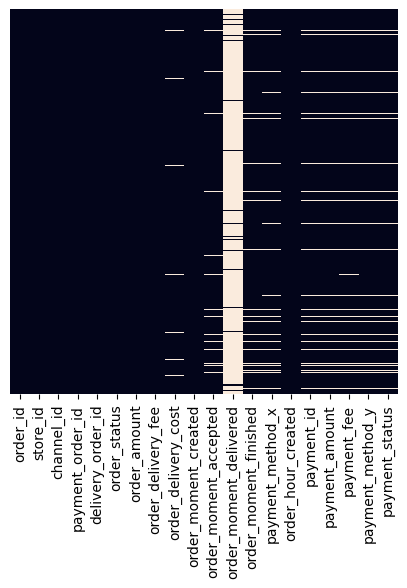

In [45]:
plt.figure(figsize=(5, 5))
sns.heatmap(merged_df.isnull(),yticklabels=False,cbar=False)
plt.show()

In [46]:
merged_df["payment_method_y"].value_counts()

payment_method_y
ONLINE                      357982
VOUCHER                      99473
DEBIT                        15331
MEAL_BENEFIT                  8213
STORE_DIRECT_PAYMENT          6899
CREDIT                        5942
DEBIT_STORE                   2548
MONEY                         2171
PAYMENT_LINK                  1887
VOUCHER_STORE                 1737
CREDIT_STORE                  1542
VOUCHER_DC                     503
INSTALLMENT_CREDIT_STORE       473
VOUCHER_OL                     439
BANK_TRANSFER_DC               364
Name: count, dtype: int64

In [47]:
merged_df["payment_method_x"].value_counts()

payment_method_x
ONLINE                      357982
VOUCHER                      99473
DEBIT                        15331
MEAL_BENEFIT                  8213
STORE_DIRECT_PAYMENT          6899
CREDIT                        5942
DEBIT_STORE                   2548
MONEY                         2171
PAYMENT_LINK                  1887
VOUCHER_STORE                 1737
CREDIT_STORE                  1542
VOUCHER_DC                     503
INSTALLMENT_CREDIT_STORE       473
VOUCHER_OL                     439
BANK_TRANSFER_DC               364
Name: count, dtype: int64

In [57]:
peak_avg_order_amount = merged_df[merged_df["order_hour_created"].isin(peak_hours['order_hour_created'])].groupby("payment_method_x")["order_amount"].mean().reset_index(name='peak_avg_order_amount')
non_peak_avg_order_amount = merged_df[~merged_df["order_hour_created"].isin(peak_hours['order_hour_created'])].groupby("payment_method_x")["order_amount"].mean().reset_index(name='non_peak_avg_order_amount')

avg_order_amount_comparison = pd.merge(peak_avg_order_amount, non_peak_avg_order_amount, on='payment_method_x')
avg_order_amount_comparison.head(20)

,payment_method_x,peak_avg_order_amount,non_peak_avg_order_amount
0,BANK_TRANSFER_DC,71.090711,78.238960
1,CREDIT,89.419572,101.480822
2,CREDIT_STORE,116.627959,168.713523
3,DEBIT,65.424041,65.315203
4,DEBIT_STORE,90.094936,102.549549
5,INSTALLMENT_CREDIT_STORE,665.093277,437.629730
6,MEAL_BENEFIT,70.336511,63.905344
7,MONEY,48.041728,47.677929
8,ONLINE,93.225391,93.632424
9,PAYMENT_LINK,101.212275,120.077885


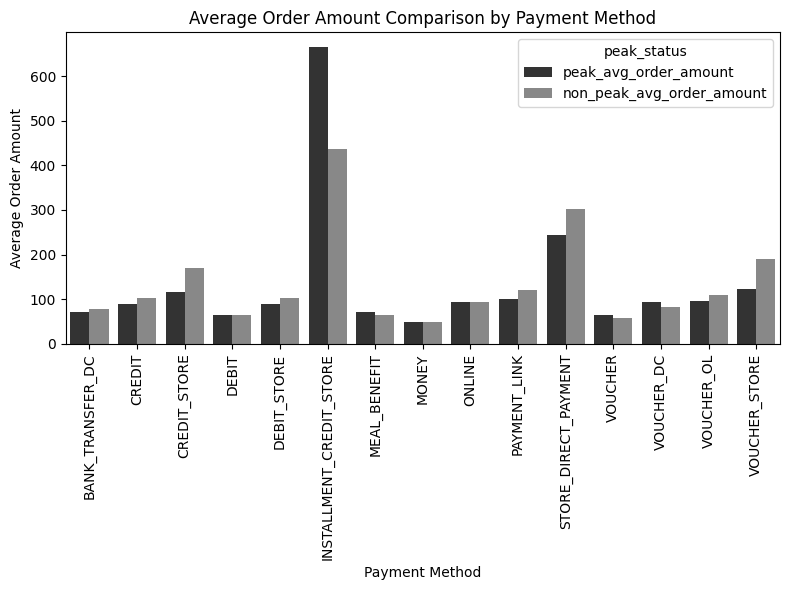

In [58]:
plt.figure(figsize=(8, 6))

avg_order_amount_comparison_melted = avg_order_amount_comparison.melt(id_vars='payment_method_x', var_name='peak_status', value_name='Average Order Amount')
sns.barplot(x='payment_method_x', y='Average Order Amount',hue='peak_status', data=avg_order_amount_comparison_melted,  palette=['#333333','#888888'])


plt.title('Average Order Amount Comparison by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Average Order Amount')
plt.xticks(rotation=90)
# plt.legend(title='hour_peak_status', labels=['Peak Hours', 'Non-Peak Hours'])


plt.tight_layout()
plt.show()

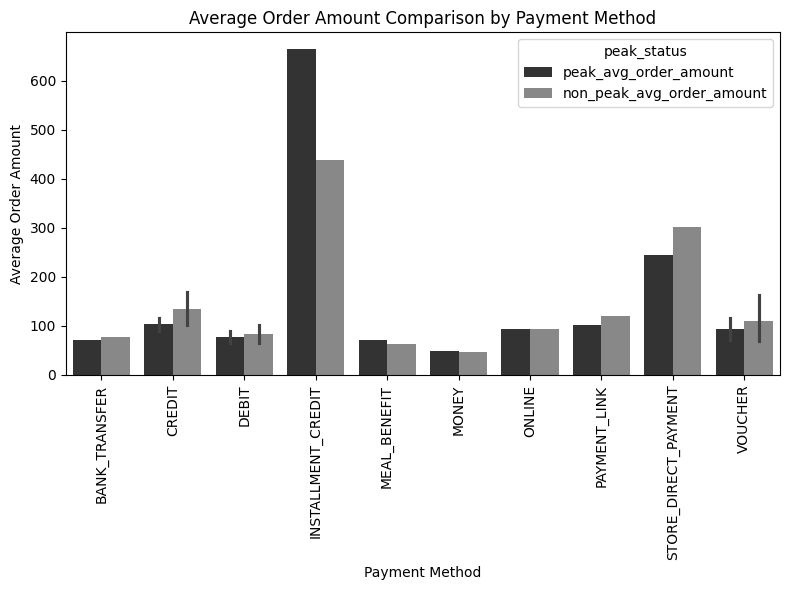

In [61]:
mapping = {
    'ONLINE': 'ONLINE',
    'VOUCHER': 'VOUCHER',
    'DEBIT': 'DEBIT',
    'MEAL_BENEFIT': 'MEAL_BENEFIT',
    'STORE_DIRECT_PAYMENT': 'STORE_DIRECT_PAYMENT',
    'CREDIT': 'CREDIT',
    'DEBIT_STORE': 'DEBIT',
    'MONEY': 'MONEY',
    'PAYMENT_LINK': 'PAYMENT_LINK',
    'VOUCHER_STORE': 'VOUCHER',
    'CREDIT_STORE': 'CREDIT',
    'VOUCHER_DC': 'VOUCHER',
    'INSTALLMENT_CREDIT_STORE': 'INSTALLMENT_CREDIT',
    'VOUCHER_OL': 'VOUCHER',
    'BANK_TRANSFER_DC': 'BANK_TRANSFER'
}
avg_order_amount_comparison['simplified_payment_method'] = avg_order_amount_comparison['payment_method_x'].map(mapping)

plt.figure(figsize=(8, 6))

avg_order_amount_comparison_melted = avg_order_amount_comparison[['simplified_payment_method','peak_avg_order_amount','non_peak_avg_order_amount']].melt(id_vars='simplified_payment_method', var_name='peak_status', value_name='Average Order Amount')
sns.barplot(x='simplified_payment_method', y='Average Order Amount',hue='peak_status', data=avg_order_amount_comparison_melted,  palette=['#333333','#888888'])


plt.title('Average Order Amount Comparison by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Average Order Amount')
plt.xticks(rotation=90)
# plt.legend(title='hour_peak_status', labels=['Peak Hours', 'Non-Peak Hours'])


plt.tight_layout()
plt.show()